#Loading dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir "/content/dataset"
!unzip -d "/content/dataset" "/content/gdrive/MyDrive/cards/Cropped-cards-suit-plus-value.v8i.tensorflow.zip"

unzip:  cannot find or open /content/gdrive/MyDrive/cards/Cropped-cards-suit-plus-value.v8i.tensorflow.zip, /content/gdrive/MyDrive/cards/Cropped-cards-suit-plus-value.v8i.tensorflow.zip.zip or /content/gdrive/MyDrive/cards/Cropped-cards-suit-plus-value.v8i.tensorflow.zip.ZIP.


#Loading packages

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.random import set_seed
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
import shutil
import cv2
import os
from tqdm import tqdm
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9675224243311559609
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13020678710645134447
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
# ! rm /content/dataset/train/train/*.xml
# ! rm /content/dataset/test/test/*.xml
# ! rm /content/dataset/train/train/C710.jpg

rm: cannot remove '/content/dataset/train/train/*.xml': No such file or directory
rm: cannot remove '/content/dataset/test/test/*.xml': No such file or directory
rm: cannot remove '/content/dataset/train/train/C710.jpg': No such file or directory


#Changing labels from suit+value to only suit

Dataset was originally labeled using Roboflow to contain both suit and value of card. However, to improve the model I decided to first only train on suit.

In [ ]:
test_dir = "/content/dataset/test/"
train_dir = "/content/dataset/train/"

labels_test = pd.read_csv("/content/dataset/test/_annotations.csv")
labels_test = labels_test[['filename', 'class']]
labels_test['class'] = labels_test['class'].apply(lambda x: x[-1])
labels_test['class_number'] = labels_test['class'].replace({'c':0, 'd':1, 'h':2, 's':3})
labels_test = pd.concat([labels_test[['filename', 'class', 'class_number']], pd.get_dummies(labels_test[['class']])], axis=1)
y_test = np.array(labels_test[['class_c','class_d','class_h','class_s']].values)

labels_train = pd.read_csv("/content/dataset/train/_annotations.csv")
labels_train = labels_train[['filename', 'class']]
labels_train['class'] = labels_train['class'].apply(lambda x: x[-1])
labels_train['class_number'] = labels_train['class'].replace({'c':0, 'd':1, 'h':2, 's':3})
labels_train = pd.concat([labels_train[['filename', 'class', 'class_number']], pd.get_dummies(labels_train[['class']])], axis=1)
y_train = np.array(labels_train['class_number'].values)

#Creating image data generators 

In [ ]:
!mkdir -p /content/dataset/for_generators/train/c
!mkdir -p /content/dataset/for_generators/train/d
!mkdir -p /content/dataset/for_generators/train/h
!mkdir -p /content/dataset/for_generators/train/s
!mkdir -p /content/dataset/for_generators/test/c
!mkdir -p /content/dataset/for_generators/test/d
!mkdir -p /content/dataset/for_generators/test/h
!mkdir -p /content/dataset/for_generators/test/s

In [ ]:
test_gen_dir = "/content/dataset/for_generators/test/"
train_gen_dir = "/content/dataset/for_generators/train/"


for i, row in tqdm(labels_test.iterrows()):
  class_name = row['class']
  filename = row['filename']
  shutil.copyfile(test_dir+filename, test_gen_dir+class_name+'/'+filename)


for i, row in tqdm(labels_train.iterrows()):
  class_name = row['class']
  filename = row['filename']
  shutil.copyfile(train_dir+filename, train_gen_dir+class_name+'/'+filename)


88it [00:00, 4451.59it/s]
1171it [00:00, 4979.97it/s]


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, brightness_range=[0.8, 1.2])
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, brightness_range=[0.8, 1.2])

train_generator = train_datagen.flow_from_directory(
        train_gen_dir,
        target_size=(416, 416),
        batch_size=25,
        class_mode='categorical')

test_generator=test_datagen.flow_from_directory(
        test_gen_dir,
        target_size=(416,416),
        batch_size=25,
        class_mode='categorical')

Found 822 images belonging to 4 classes.
Found 61 images belonging to 4 classes.


Let's take a look at our images.

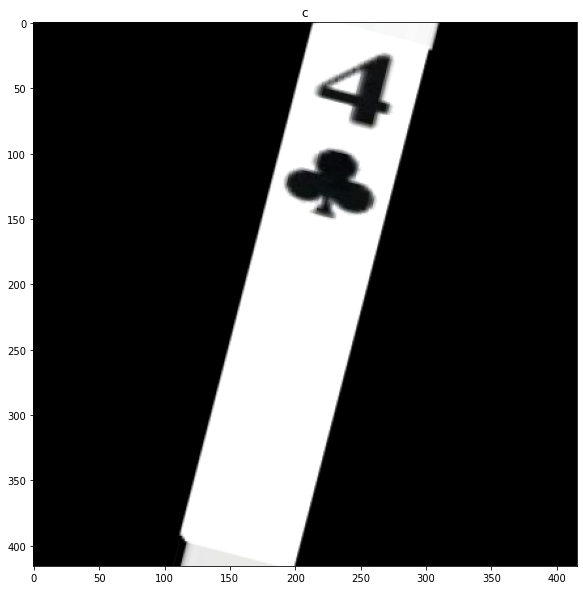

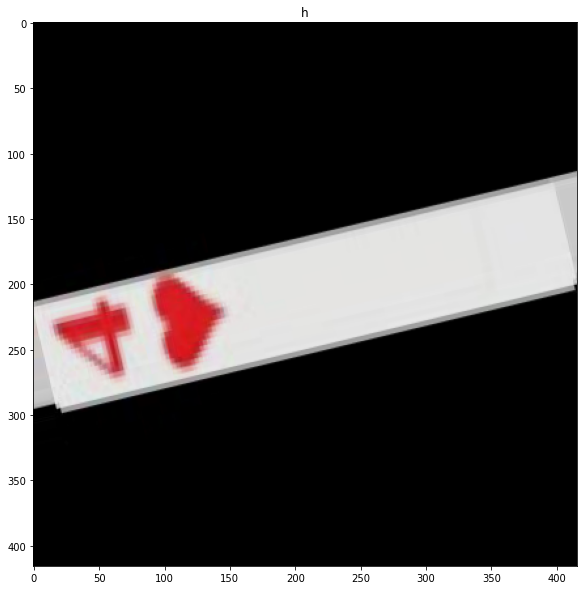

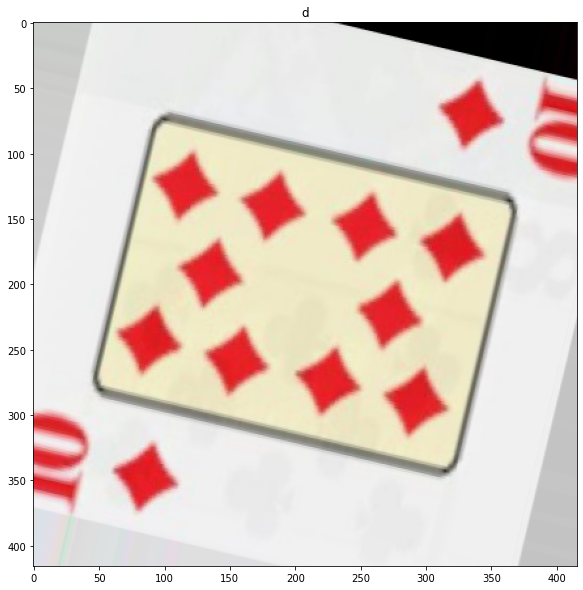

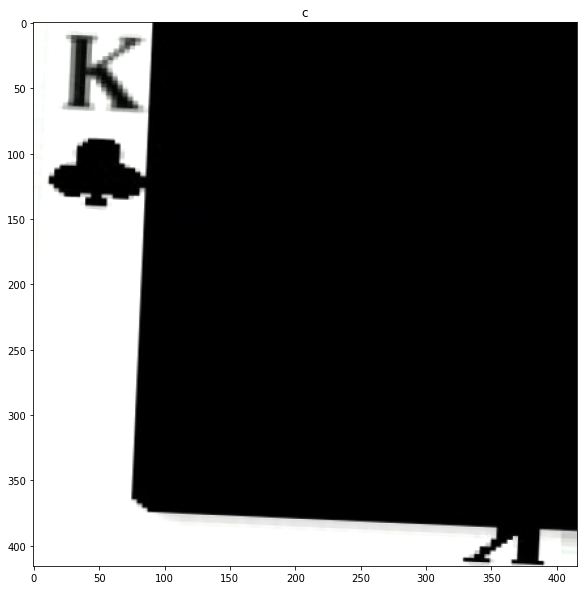

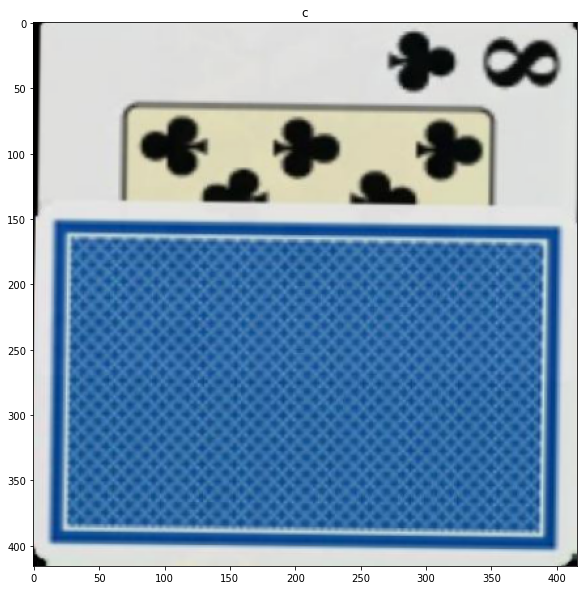

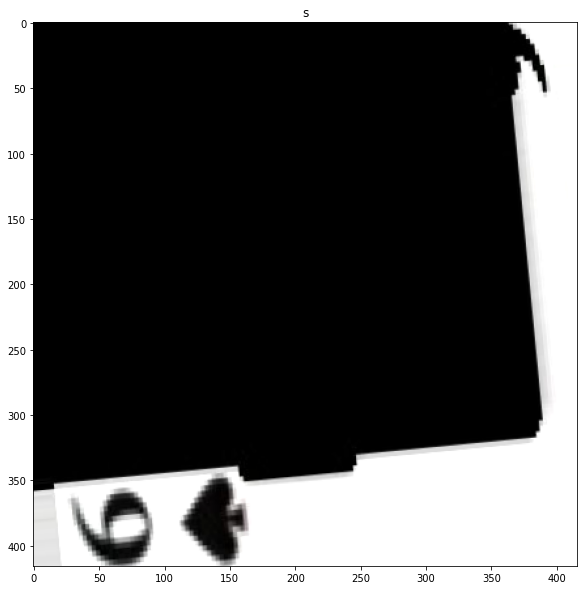

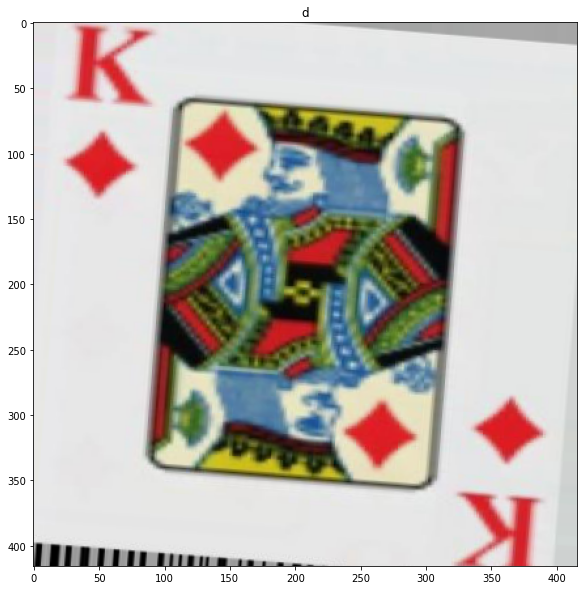

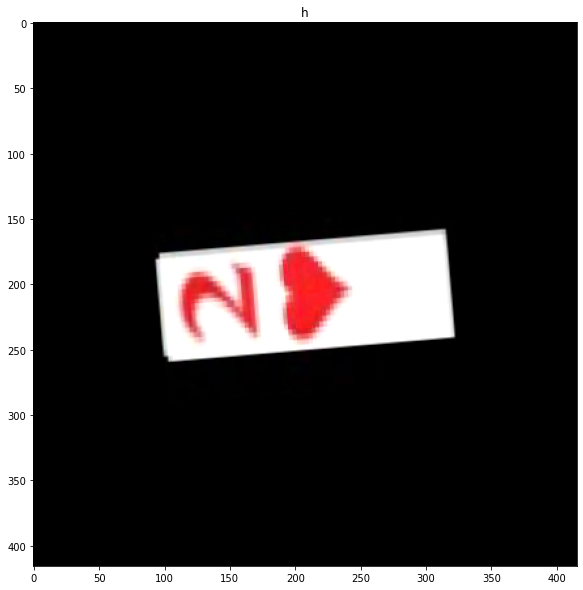

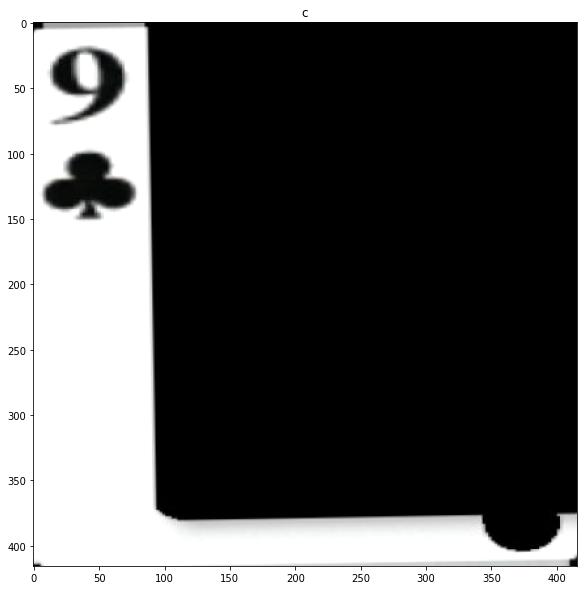

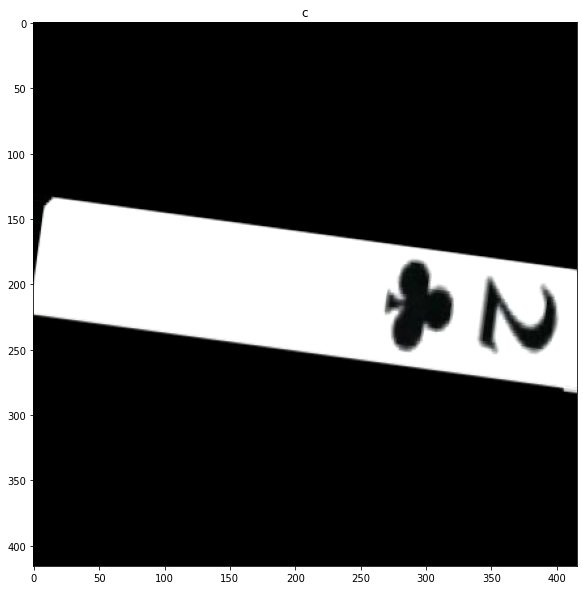

In [ ]:
labels_arr=['c', 'd', 'h', 's']
batch = train_generator.next()
for i in range(10):
  plt.figure(figsize=(10,10))
  plt.title(labels_arr[np.argmax(batch[1][i])])
  plt.imshow(batch[0][i])
  plt.show() 

#Building model

In [ ]:
def my_net(dropout=False , dropout_value = 0.0):

  model = models.Sequential()

  model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(416, 416, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [ ]:
model = my_net(True, 0.2) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 414, 414, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 207, 207, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 207, 207, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 205, 205, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 102, 102, 128)    0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 102, 102, 128)     0

#Training model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

estimator_model = tf.keras.estimator.model_to_estimator(keras_model = model,model_dir = '/content/gdrive/MyDrive/Runs/tensorflow_models/frozen')

history = model.fit(
              train_generator,
              steps_per_epoch=len(labels_train)//100,
              epochs=100,
              validation_data=test_generator,
              validation_steps=len(labels_test)//50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/MyDrive/Runs/tensorflow_models/frozen', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas':

Accuracy of the model doesn't look to good, but it will work for first try.

I'll see what I can do to improve model results. Changes can be done either to network structure or to dataset.

#Saving model

In [ ]:
model.save('/content/gdrive/MyDrive/Runs/tensorflow_models/model_mast.h5')

#Testing model results on images from test dataset.

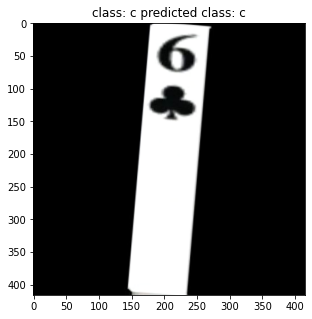

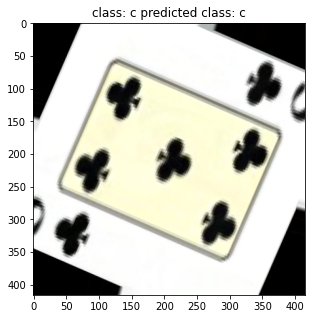

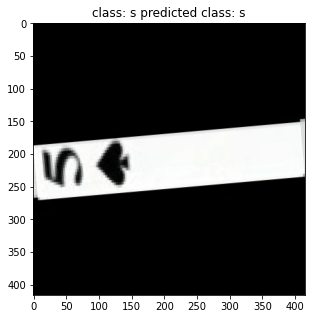

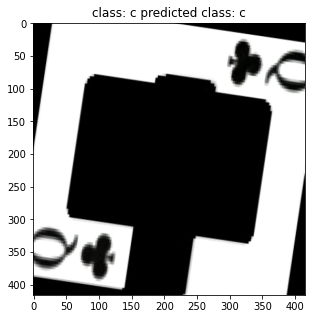

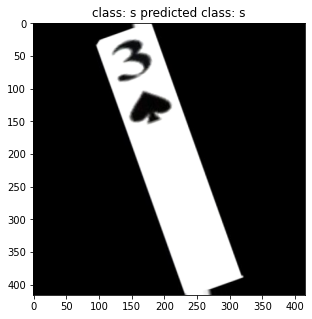

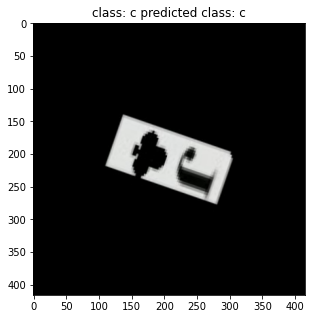

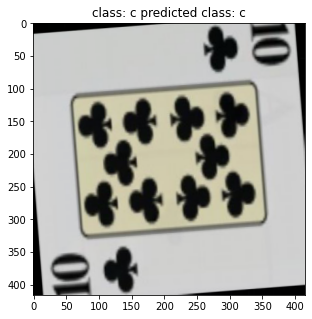

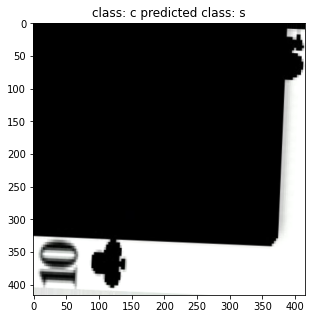

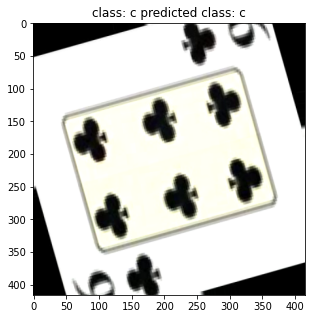

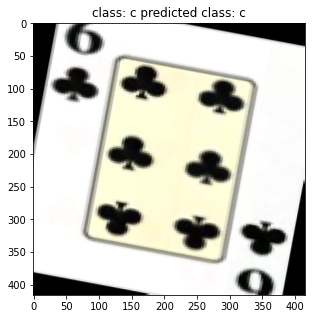

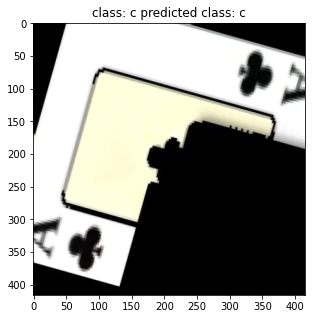

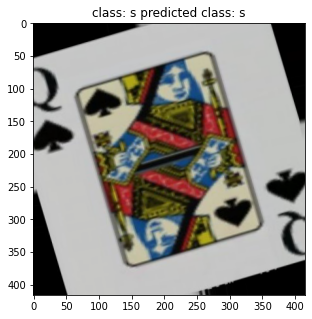

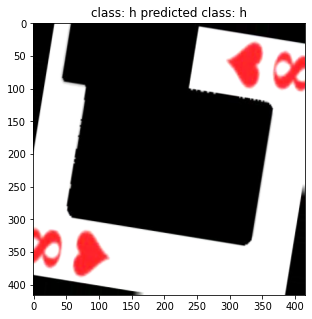

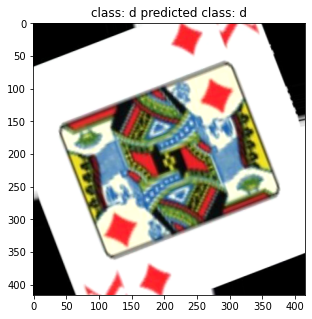

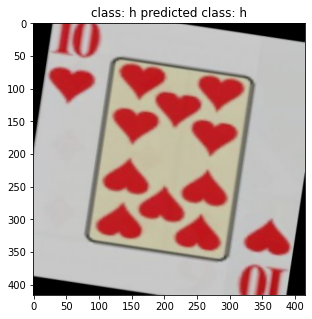

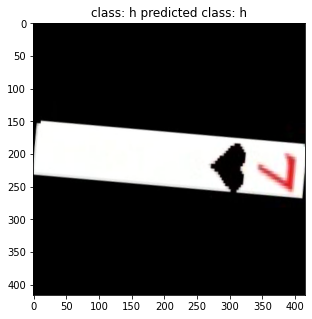

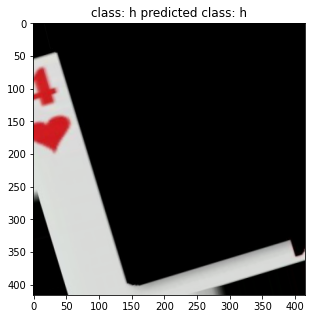

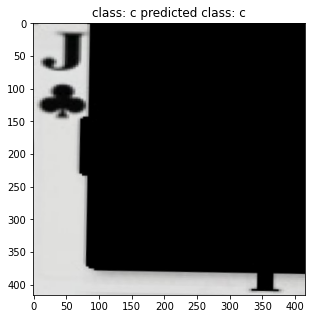

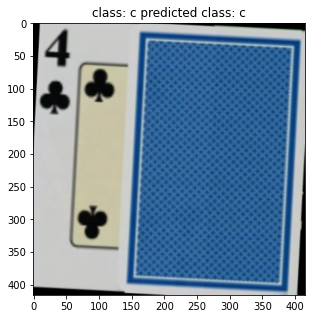

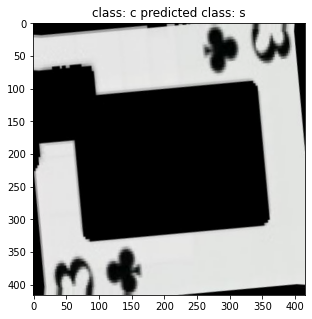

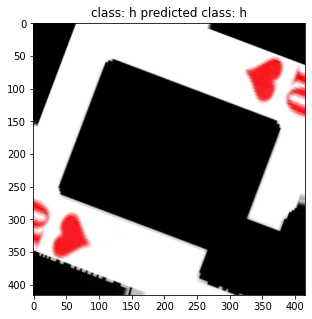

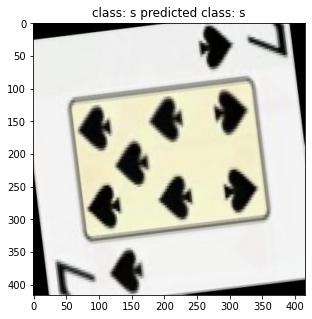

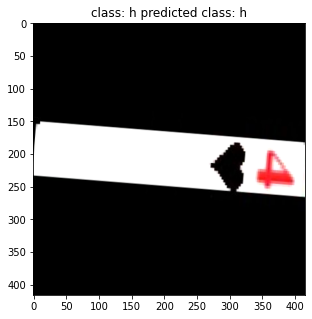

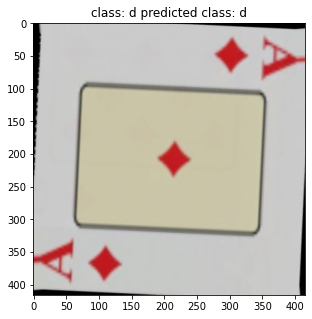

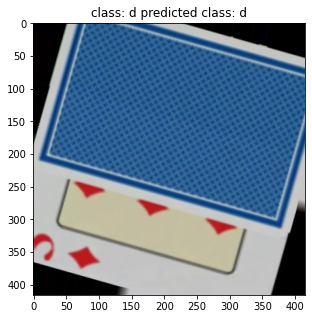

In [ ]:
# test usage

labels_arr=['c', 'd', 'h', 's']
batch = train_generator.next()
res = model.predict(batch[0])
for i in range(25):
  plt.figure(figsize=(5,5))
  plt.title("class: " + labels_arr[np.argmax(batch[1][i])] + ' predicted class: ' + labels_arr[np.argmax(res[i])])
  plt.imshow(batch[0][i])
  plt.show() 

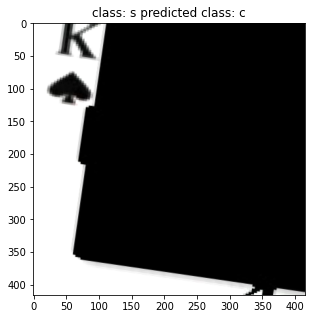

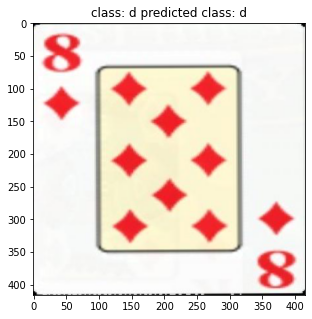

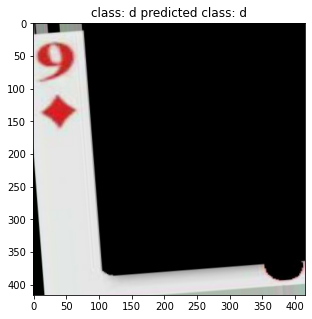

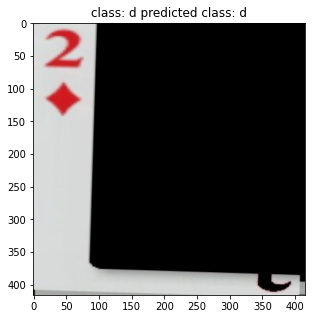

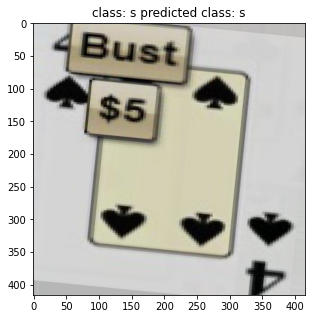

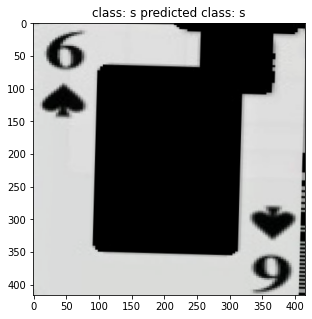

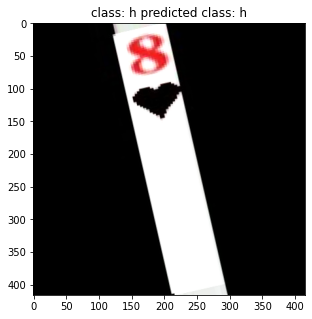

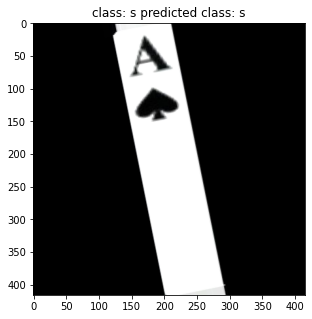

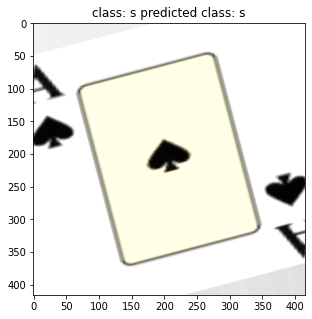

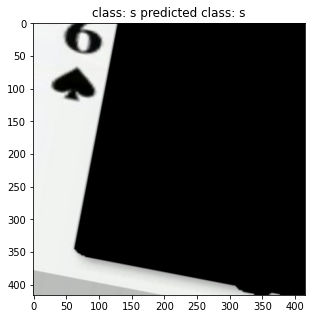

In [ ]:
# test usage

labels_arr=['c', 'd', 'h', 's']
batch = test_generator.next()
res = model.predict(batch[0])

for i in range(10):
  plt.figure(figsize=(5,5))
  plt.title("class: " + labels_arr[np.argmax(batch[1][i])] + ' predicted class: ' + labels_arr[np.argmax(res[i])])
  plt.imshow(batch[0][i])
  plt.show() 